In [ ]:
# !pip install kneed
# !pip install KDEpy

In [ ]:
import sys
import os
import datacube
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import warnings
# import phenopy as phen
from scipy.integrate import trapz
from scipy.stats import skew

sys.path.append('../Scripts')
from deafrica_plotting import display_map
from deafrica_datahandling import mostcommon_crs, load_ard
from deafrica_bandindices import calculate_indices


%load_ext autoreload
%autoreload 2

In [ ]:
dc = datacube.Datacube(app='phenology stats')

In [ ]:
lat, lon = 10.4324, -0.9937
buffer = 0.00075

x = (lon - buffer, lon + buffer)
y =  (lat + buffer, lat - buffer)

# Create a reusable query
query = {
    'x': x,
    'y': y,
    'time': ('2018-01', '2018-12'),
    'resolution': (-20, 20)
}

In [ ]:
# display_map(x=x, y=y)

In [ ]:
#find the most common UTM crs for the location
output_crs = mostcommon_crs(dc=dc, product='s2a_msil2a', query=query)

# Load available data
ds = load_ard(dc=dc, 
              products=['s2a_msil2a', 's2b_msil2a'],
              measurements=['red', 'nir_1'],
              group_by='solar_day',
              output_crs=output_crs, 
              **query)

# Print output data
print(ds)

In [ ]:
# First we calculate NDVI on each image in the timeseries
ndvi = calculate_indices(ds, index='NDVI', collection='s2', drop=True)
ndvi = ndvi.NDVI
x = ndvi.mean(['x', 'y'])

In [5]:
import numpy as np
import xarray as xr
import pandas as pd
from scipy.integrate import trapz
from scipy.stats import skew


def _getPhenologyMetrics(da, doy):
    """
    Obtain land surfurface phenology metrics
    Parameters
    ----------
    - da:  xr.Datarray
    - doy: xt.DataArray
        Dayofyer values for each time step in the 'time'
        dim on 'da'. e.g doy=da.time.dt.dayofyear
    Outputs
    -------
        SOS = DOY of start of season
        POS = DOY of peak of season
        EOS = DOY of end of season
        vSOS = Value at start of season
        vPOS = Value at peak of season
        vEOS = Value at end of season
        LOS = Length of season (DOY)
        AOS = Amplitude of season (in value units)
        IOS = Integral of season (SOS-EOS)
        ROG = Rate of greening
        ROS = Rate of senescence
        SW = Skewness of growing season
    """

    # basic variables
    vpos = np.nanmax(da)
    ipos = np.where(da == vpos)[0]
    pos = doy[ipos]
    trough = np.nanmin(da)
    ampl = vpos - trough

    # get position of seasonal peak and trough
    ipos = np.where(da == vpos)

    # scale annual time series to 0-1
    ratio = (da - trough) / ampl

    # separate greening from senesence values
    dev = np.gradient(ratio)  # first derivative
    greenup = np.zeros([ratio.shape[0]],  dtype=bool)
    greenup[dev > 0] = True

    # estimate SOS and EOS as median of the seasons
    i = np.nanmedian(doy[:ipos[0][0]][greenup[:ipos[0][0]]])
    ii = np.nanmedian(doy[ipos[0][0]:][~greenup[ipos[0][0]:]])
    sos = doy[(np.abs(doy - i)).argmin()]
    eos = doy[(np.abs(doy - ii)).argmin()]
    isos = np.where(doy == int(sos))[0]
    ieos = np.where(doy == eos)[0]
    if sos is None:
        isos = 0
        sos = doy[isos]
    if eos is None:
        ieos = len(doy) - 1
        eos = doy[ieos]

    # los: length of season
    los = eos - sos
    if los < 0:
        los[los < 0] = len(da) + \
            (eos[los < 0] - sos[los < 0])

    # doy of growing season
    green = doy[(doy > sos) & (doy < eos)]
    _id = []
    for i in range(len(green)):
        _id.append((doy == green[i]).nonzero()[0])

    # index of growing season
    _id = np.array([item for sublist in _id for item in sublist])
    # get intergral of green season
    ios = trapz(da[_id], doy[_id])

    # rate of greening [slope SOS-POS]
    rog = (vpos - da[isos]) / (pos - sos)
    rog = rog[0]

    # rate of senescence [slope POS-EOS]
    ros = (da[ieos] - vpos) / (eos - pos)
    ros= ros[0]

    # skewness of growing season
    sw = skew(da[_id])

    #values at start of season
    vsos = da[isos][0]

    #values at end of season
    veos = da[ieos][0]

    print(sos,pos[0],eos, vsos, vpos, veos, los, ampl, ios, rog, ros, sw)

    #return metrics
        
#create fake data
ndvi = np.array([0,0.0,0.2, 0.5, 0.9, 0.9, 0.9, 0.8, 0.75, 0.1, 0.0, 0.0])
test_da = xr.DataArray(ndvi,
             coords=[pd.date_range("01/01/2018", periods=12, freq=pd.DateOffset(months=1),)],dims="time")

doy=test_da.time.dt.dayofyear

xr.apply_ufunc(
        _getPhenologyMetrics,
        test_da,
        input_core_dims=[["time"]],
        kwargs={'doy': doy.values},
        dask='allowed'
        )

60 121 244 0.2 0.9 0.75 184 0.9 102.25 0.011475409836065573 -0.0012195121951219514 -1.290994448735806


<xarray.DataArray ()>
array(None, dtype=object)

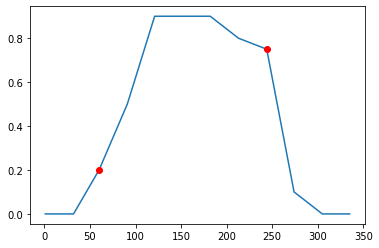

In [16]:
ax = plt.subplot(1, 1, 1)
ax.plot(doy, ndvi)
ax.plot(60,0.2, "or")
ax.plot(244,0.75, "or")

In [8]:
import matplotlib.pyplot as plt

In [ ]:
#create fake data
ndvi = np.array([0,0.0,0.2, 0.5, 0.9, 0.9, 0.9, 0.8, 0.75, 0.1, 0.0, 0.0])
test_da = xr.DataArray(ndvi,
             coords=[pd.date_range("01/01/2018", periods=12, freq=pd.DateOffset(months=1),)],dims="time")

doy=test_da.time.dt.dayofyear
test_da.plot()


In [ ]:
xr.apply_ufunc(
        _getPhenologyMetrics,
        test_da,
        input_core_dims=[["time"]],
        kwargs={'doy': doy.values},
        dask='allowed'
        )

In [ ]:
def TIMESAT_stats(da, doy):
   
    #empty dict to put results in
    stats = {}
    
    data_np_arr = da
    time_np_arr = doy
    data_inds = np.arange(len(data_np_arr))
    
    # Obtain the first and second derivatives.
    fst_deriv = np.gradient(data_np_arr, time_np_arr)
    pos_fst_deriv = fst_deriv > 0
    neg_fst_deriv = 0 > fst_deriv
    snd_deriv = np.gradient(fst_deriv, time_np_arr)
    pos_snd_deriv = snd_deriv > 0
    neg_snd_deriv = 0 > snd_deriv
    
    # Determine MOS.
    # MOS is the index of the highest value immediately preceding a transition
    # of the first derivative from positive to negative.
    pos_to_neg_fst_deriv = pos_fst_deriv.copy()
    for i in range(len(pos_fst_deriv)):
        if i == len(pos_fst_deriv) - 1: # last index
            pos_to_neg_fst_deriv[i] = False
        elif pos_fst_deriv[i] and not pos_fst_deriv[i+1]: # + to -
            pos_to_neg_fst_deriv[i] = True
        else: # everything else
            pos_to_neg_fst_deriv[i] = False
    idxmos_potential_inds = data_inds[pos_to_neg_fst_deriv]
    idxmos_subset_ind = np.argmax(data_np_arr[pos_to_neg_fst_deriv])
    idxmos = idxmos_potential_inds[idxmos_subset_ind]
    stats['Middle of Season'] = idxmos
    
    data_inds_after_mos = np.roll(data_inds, len(data_inds)-idxmos-1)
    
    # Determine BOS.
    # BOS is the first negative inflection point of the positive values 
    # of the first derivative starting after and ending at the MOS.
    idxbos = data_inds_after_mos[np.argmax((pos_fst_deriv & neg_snd_deriv)[data_inds_after_mos])]
    stats['Beginning of Season'] = idxbos
    
    # Determine EOS.
    # EOS is the last positive inflection point of the negative values 
    # of the first derivative starting after and ending at the MOS.
    idxeos = data_inds_after_mos[np.argmax((neg_fst_deriv & pos_snd_deriv)[data_inds_after_mos][::-1])]
    stats['End of Season'] = idxeos
    
    # Determine EOS-BOS.
    stats['Length of Season'] = idxeos - idxbos
    # Determine BASE.
    stats['Base Value'] = np.nanmin(data_np_arr)
    # Determine MAX.
    stats['Max Value'] = np.nanmax(data_np_arr)
    # Determine AMP.
    stats['Amplitude'] = stats['Max Value'] - stats['Base Value']
    
    #Rate of greening [slope StartOS-PeakOS]
    da[idxmos] - da[idxbos / 
    
    print(stats)
    return stats

In [ ]:
xr.apply_ufunc(
        TIMESAT_stats, x,
        input_core_dims=[["time"]],
        kwargs={'doy': doy.values},
        dask='allowed'
        )

In [ ]:
#function wants a raster input, doesnt work on xarray

# doy=ndvi.time.dt.dayofyear

# phen.PhenoLSP(inData=ndvi.NDVI.values, outData='phen_metrics.tif', nGS=46, doy=doy, phentype=2,
#   n_jobs=2, chuckSize=32)

In [ ]:
# doy=ndvi.time.dt.dayofyear
# xnew = np.linspace(np.min(doy), np.max(doy), len(doy), dtype='int16')

In [ ]:
# xr.apply_ufunc(phen._getLSPmetrics,
#                ndvi,
#                kwargs={'doy':doy,
#                        'num':16,
#                        'nGS':1,
#                        'phentype': 2
#                       })